In [20]:
from imutils.video import VideoStream
import argparse
import datetime
import imutils
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as mse

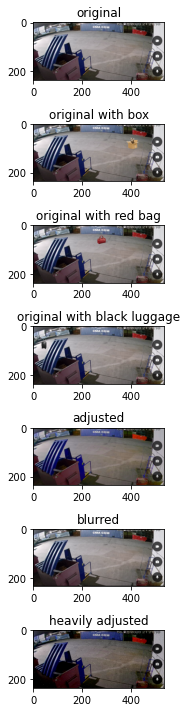

In [21]:
images = {}
names = ['original','original with box','original with red bag','original with black luggage','adjusted','blurred',
        'heavily adjusted']
fig=plt.figure(figsize=(20, 10))
ax = []
for name in names:
    images[name] = cv2.imread(f'images/{name}.png')
    ax.append(fig.add_subplot(len(names),1,len(ax)+1))
    ax[-1].set_title(f'{name}')
    plt.imshow(cv2.cvtColor(images[name], cv2.COLOR_RGB2BGR))
plt.tight_layout()

In [42]:
def check_for_suspicious_object(ref,comp):
    blur_kernel_size = (7,7)
    threshold = 25
    dilate_iterations = 2
    bounding_area = 400
    ssim_threshold = 0.5 #keep only areas less than this
    mse_threshold = 0.35 #keep only areas more than this
    motion = False

    baseline_image = ref.copy()
    comparison_image = comp.copy()

    baseline_image_ = cv2.GaussianBlur(cv2.cvtColor(baseline_image, cv2.COLOR_BGR2GRAY), blur_kernel_size, 0)
    comparison_image_ = cv2.GaussianBlur(cv2.cvtColor(comparison_image, cv2.COLOR_BGR2GRAY), blur_kernel_size, 0)

    image_delta = cv2.absdiff(baseline_image_, comparison_image_)
    plt.imshow(image_delta)

    final_image = comparison_image.copy()
    thresh = cv2.threshold(image_delta, threshold, 255, cv2.THRESH_BINARY)[1]
    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    dilated = cv2.dilate(thresh, None, iterations=dilate_iterations)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # loop over the contours
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        # ignore if contour area is too small, or the size of the entire frame (means lighting conditions changed)
#         print([w,h],ref.shape[:-1])
        if cv2.contourArea(c) < bounding_area or w < 7 or h < 7 or np.allclose([h,w],ref.shape[:-1],atol = 20):
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        baseline_area = baseline_image[y:y+h, x:x+w]
        comparison_area = comparison_image[y:y+h, x:x+w]
        if ssim(baseline_area,comparison_area,multichannel=True) < ssim_threshold or mse(baseline_area,comparison_area) > mse_threshold:
            cv2.rectangle(final_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            motion = True
    return motion,final_image

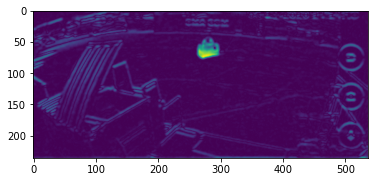

In [60]:
motion,final_image = check_for_suspicious_object(images['blurred'],images['original with red bag'])

True


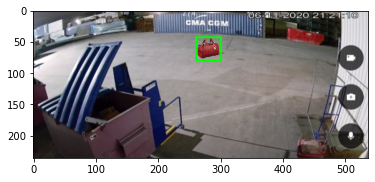

In [61]:
print(motion)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

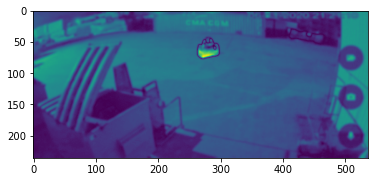

In [53]:
motion,final_image = check_for_suspicious_object(images['adjusted'],images['original with red bag'])

False


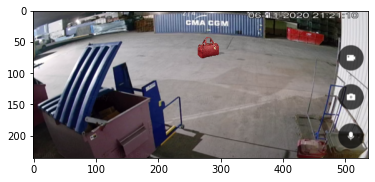

In [54]:
print(motion)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

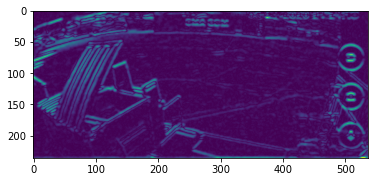

In [45]:
motion,final_image = check_for_suspicious_object(images['blurred'],images['original'])

False


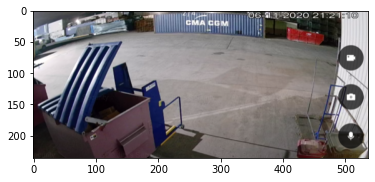

In [46]:
print(motion)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

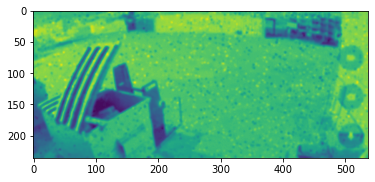

In [47]:
motion,final_image = check_for_suspicious_object(images['heavily adjusted'],images['original'])

False


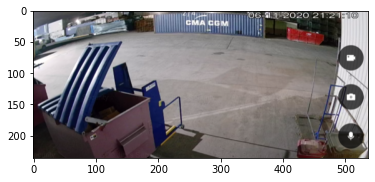

In [48]:
print(motion)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

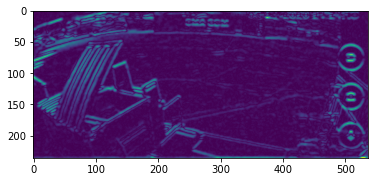

In [56]:
motion,final_image = check_for_suspicious_object(images['blurred'],images['original'])

False


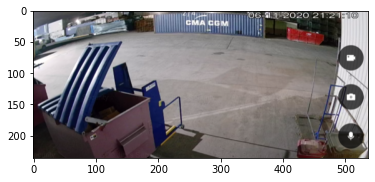

In [57]:
print(motion)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))